In [1]:
# 02c — Gravity features (value + gradient), aligned to polygon-masked grid

import os, sys
import numpy as np
import joblib
import rasterio
from rasterio.windows import from_bounds
from pathlib import Path

# Add project root for src imports
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.data_utils import state_polygon
# If you have a helper: from src.features import sample_raster_to_grid

STATE = "Missouri"
GRID_PATH = project_root / "data/processed/grid_gdf.joblib"
SRC_RASTER = project_root / "data/raw/gravity_conus.tif"   # national or regional raster
CLIP_RASTER = project_root / "data/raw/gravity_state.tif"  # will be (re)written for the current grid

# 1) Load grid (authoritative)
grid = joblib.load(GRID_PATH)
N = len(grid)
assert N > 0, "Grid is empty; run 02a_build_grid_and_coords first."
if grid.crs is None:
    grid = grid.set_crs(4326)
elif grid.crs.to_epsg() != 4326:
    grid = grid.to_crs(4326)

# 2) Clip the raster to the grid bbox (fast); we’ll sample per-cell from this clip
bbox = grid.total_bounds  # (minx, miny, maxx, maxy)
os.makedirs(Path(CLIP_RASTER).parent, exist_ok=True)

with rasterio.open(SRC_RASTER) as src:
    win = from_bounds(*bbox, transform=src.transform)
    data = src.read(1, window=win)
    transform = rasterio.windows.transform(win, src.transform)
    profile = src.profile
    profile.update({"height": data.shape[0], "width": data.shape[1], "transform": transform})

    with rasterio.open(CLIP_RASTER, "w", **profile) as dst:
        dst.write(data, 1)

# 3) Sample gravity value at each grid cell centroid
with rasterio.open(CLIP_RASTER) as src:
    arr = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        arr[arr == nodata] = np.nan

    rows, cols = [], []
    for pt in grid.geometry.centroid:
        r, c = src.index(pt.x, pt.y)
        r = np.clip(r, 0, arr.shape[0]-1)
        c = np.clip(c, 0, arr.shape[1]-1)
        rows.append(r); cols.append(c)

    vals = arr[rows, cols]
    vals = np.nan_to_num(vals, nan=float(np.nanmean(vals)))

# 4) Gradient magnitude, sampled per grid cell (NOT flattened image)
gy, gx = np.gradient(np.nan_to_num(arr, nan=float(np.nanmean(arr))))
grad = np.hypot(gx, gy)
grad_vals = grad[rows, cols]
grad_vals = np.nan_to_num(grad_vals, nan=float(np.nanmean(grad_vals)))

# 5) Save arrays — they must be length N
np.save(project_root / "data/processed/X_gravity.npy", vals.reshape(N))
np.save(project_root / "data/processed/X_gravity_grad.npy", grad_vals.reshape(N))

print("Saved X_gravity.npy:", vals.shape, "| X_gravity_grad.npy:", grad_vals.shape)
assert vals.shape[0] == N and grad_vals.shape[0] == N, "Gravity arrays must match grid length."


C:\Users\angel\AppData\Local\Temp\ipykernel_51808\2734027468.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for pt in grid.geometry.centroid:


Saved X_gravity.npy: (7646,) | X_gravity_grad.npy: (7646,)


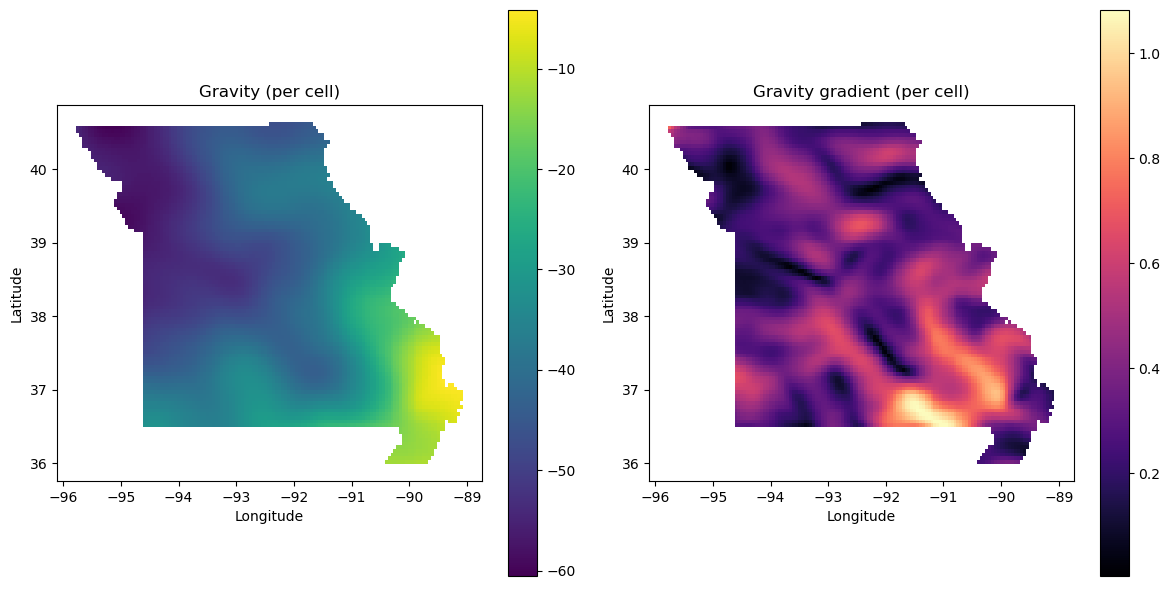

Saved figures/gravity_maps.png


In [2]:
# --- Gravity feature maps ---
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

os.makedirs(project_root / "figures", exist_ok=True)

gplot = grid.copy()
gplot["grav"]  = np.load(project_root / "data/processed/X_gravity.npy").reshape(-1)

grad_path = project_root / "data/processed/X_gravity_grad.npy"
has_grad = os.path.exists(grad_path)
if has_grad:
    gplot["ggrad"] = np.load(grad_path).reshape(-1)

if has_grad:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    gplot.plot(column="grav",  cmap="viridis", legend=True, ax=axes[0])
    axes[0].set_title("Gravity (per cell)")
    axes[0].set_xlabel("Longitude"); axes[0].set_ylabel("Latitude")
    gplot.plot(column="ggrad", cmap="magma",  legend=True, ax=axes[1])
    axes[1].set_title("Gravity gradient (per cell)")
    axes[1].set_xlabel("Longitude"); axes[1].set_ylabel("Latitude")
    plt.tight_layout(); plt.savefig(project_root / "figures/gravity_maps.png", dpi=180); plt.show()
    print("Saved figures/gravity_maps.png")
else:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    gplot.plot(column="grav", cmap="viridis", legend=True, ax=ax)
    ax.set_title("Gravity (per cell)")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    plt.tight_layout(); plt.savefig("figures/gravity_map.png", dpi=180); plt.show()
    print("Saved figures/gravity_map.png")
